# Plot Most Used Resources

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

flnm = './data/llama3_metrics.json'
# Open and read the JSON file
with open(flnm, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Format data like this: "category":<Nome LLM>, "total":<Somma documenti Usati> in Tutti i K, "diff":{}
# [t.results.AI.metadata.source_type for t in test_output_dicts]
# data = [
#     {"category": "theory", "total": 10, "diff": {"easy": 9, "medium": 1, "hard": 0}},
#     ...
# ]
def remap_data(run_output_dict:dict):
    plot_data = []

    unique_list_of_model_names = list(set([test_output_dict["model_name"] for test_output_dict in run_output_dict]))
    lists_source_types = ["WebArticle", "SupervisedForum", "UNSupervisedForum"]

    DO_LOGS = False
    for model_name in unique_list_of_model_names:
        if DO_LOGS: print(f"===> [PLOT] MODEL {model_name} <===")
        # Get all the test outputs for the current model
        test_output_dicts = [test_output_dict for test_output_dict in run_output_dict if test_output_dict["model_name"] == model_name]

        X, Y = [],[]
        tmp_data = {"category":model_name, "total":0, "diff":{"WebArticle":0, "SupervisedForum":0, "UNSupervisedForum":0}}
        for test_dict in test_output_dicts:
            if DO_LOGS: print("START WITH K=",test_dict["K_documents_retrieved"])
            if test_dict["K_documents_retrieved"] == 0:
                if DO_LOGS: print("SKIPPING FOR K=0\n\n")
                continue
            for idx, qa_single_test in enumerate(test_dict["results"]):
                for document in test_dict["results"][idx]["AI"]["metadata"]:
                    tmp_type = document["source_type"]
                    if not True: print(tmp_type)

                    if tmp_type not in tmp_data["diff"]:
                        raise Exception(f"Error!! Source Type {(tmp_type)} not valid??")
                    tmp_data["diff"][tmp_type] += 1
                    tmp_data["total"] += 1
            if DO_LOGS: print("END WITH K=",test_dict["K_documents_retrieved"],"\n\n")
        plot_data.append(tmp_data)

    return plot_data

data = remap_data(data)

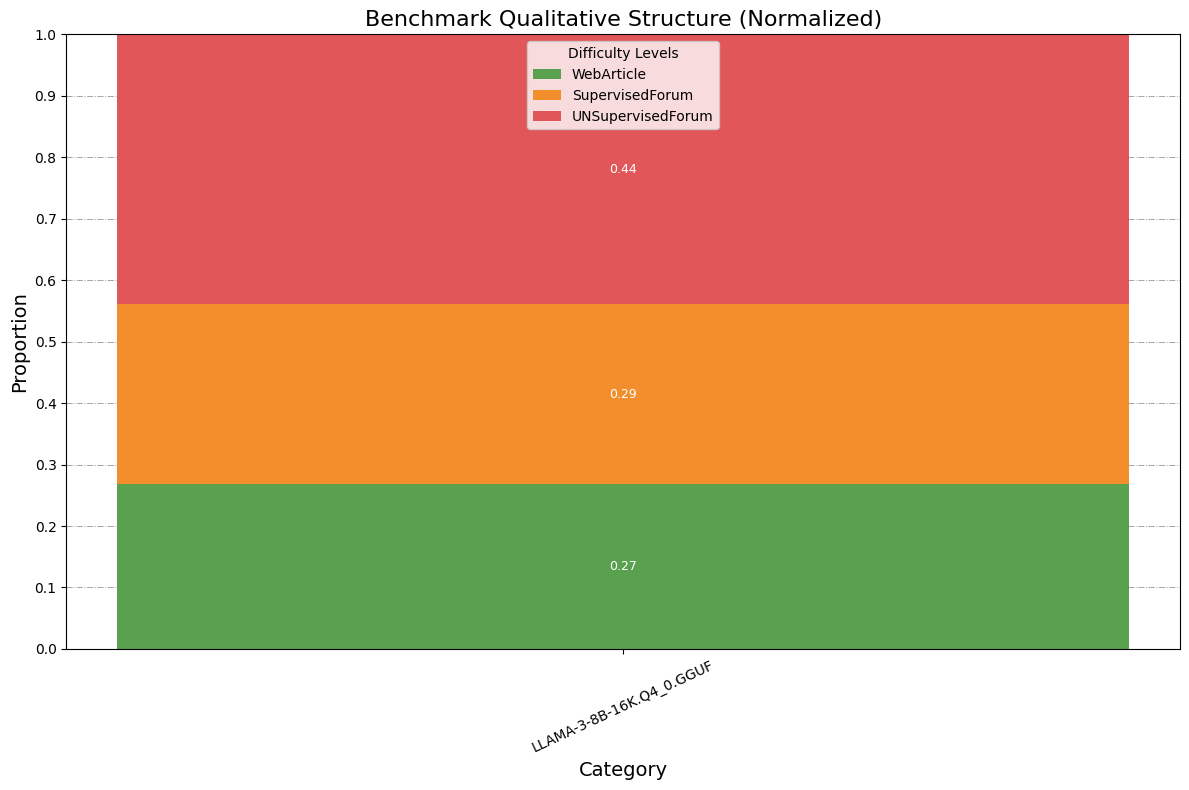

In [3]:
# Sort the data based on the total count (descending)
data = sorted(data, key=lambda x: x["total"], reverse=True)

# Extracting sorted data for the chart
categories = [item["category"].upper() for item in data]
easy_values = [item["diff"]["WebArticle"] for item in data]
medium_values = [item["diff"]["SupervisedForum"] for item in data]
hard_values = [item["diff"]["UNSupervisedForum"] for item in data]
total_values = [item["total"] for item in data]

# Normalize the values to calculate frequencies
normalized_easy = [easy / total if total > 0 else 0 for easy, total in zip(easy_values, total_values)]
normalized_medium = [medium / total if total > 0 else 0 for medium, total in zip(medium_values, total_values)]
normalized_hard = [hard / total if total > 0 else 0 for hard, total in zip(hard_values, total_values)]

# Bar width
bar_width = 0.6

# X locations for the categories
x = np.arange(len(categories))

# Custom colors
easy_color = '#59a14e'   # Green
medium_color = '#f28e2b' # Orange
hard_color = '#e15759'   # Red

# Maximum y-limit for proportions
y_max = 1.0

# Creating the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Adding horizontal dash-dotted grid lines below the bars
ax.grid(True, which='major', axis='y', linestyle='-.', linewidth=0.7, color='gray', alpha=0.7, zorder=0)

# Stacking the bars with a higher zorder to ensure they appear above the grid
bars_easy = ax.bar(x, normalized_easy, bar_width, label='WebArticle', color=easy_color, zorder=2)
bars_medium = ax.bar(x, normalized_medium, bar_width, bottom=normalized_easy, label='SupervisedForum', color=medium_color, zorder=2)
bars_hard = ax.bar(x, normalized_hard, bar_width, bottom=np.add(normalized_easy, normalized_medium), label='UNSupervisedForum', color=hard_color, zorder=2)

# Adding labels inside the bars
for i in range(len(categories)):
    # Easy label
    if normalized_easy[i] > 0:
        ax.text(x[i], normalized_easy[i] / 2, f'{normalized_easy[i]:.2f}', ha='center', va='center', color='white', fontsize=9)
    # Medium label
    if normalized_medium[i] > 0:
        ax.text(x[i], normalized_easy[i] + normalized_medium[i] / 2, f'{normalized_medium[i]:.2f}', ha='center', va='center', color='white', fontsize=9)
    # Hard label
    if normalized_hard[i] > 0:
        ax.text(x[i], normalized_easy[i] + normalized_medium[i] + normalized_hard[i] / 2, f'{normalized_hard[i]:.2f}', ha='center', va='center', color='white', fontsize=9)

# Setting y-axis ticks for proportions
y_axis_step = 0.1
ax.set_yticks(np.arange(0, y_max + y_axis_step, y_axis_step))

# Adding labels and title
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_title('Benchmark Qualitative Structure (Normalized)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=25, ha='center')  # Centered x-tick labels
ax.set_ylim(0, y_max)

# Adding the legend
ax.legend(title='Difficulty Levels', loc='upper center')

# Display the plot
plt.tight_layout()
plt.show()


In [4]:
n_webarticles = 28+18+48+20
n_supervised_forums = 0+83+50+254+1143
n_unsupervised_forums = 208+10
T = n_webarticles + n_supervised_forums + n_unsupervised_forums
print(n_webarticles, n_supervised_forums, n_unsupervised_forums, T)
print(n_webarticles/T, n_supervised_forums/T, n_unsupervised_forums/T, T)


114 1530 218 1862
0.061224489795918366 0.8216970998925887 0.11707841031149302 1862


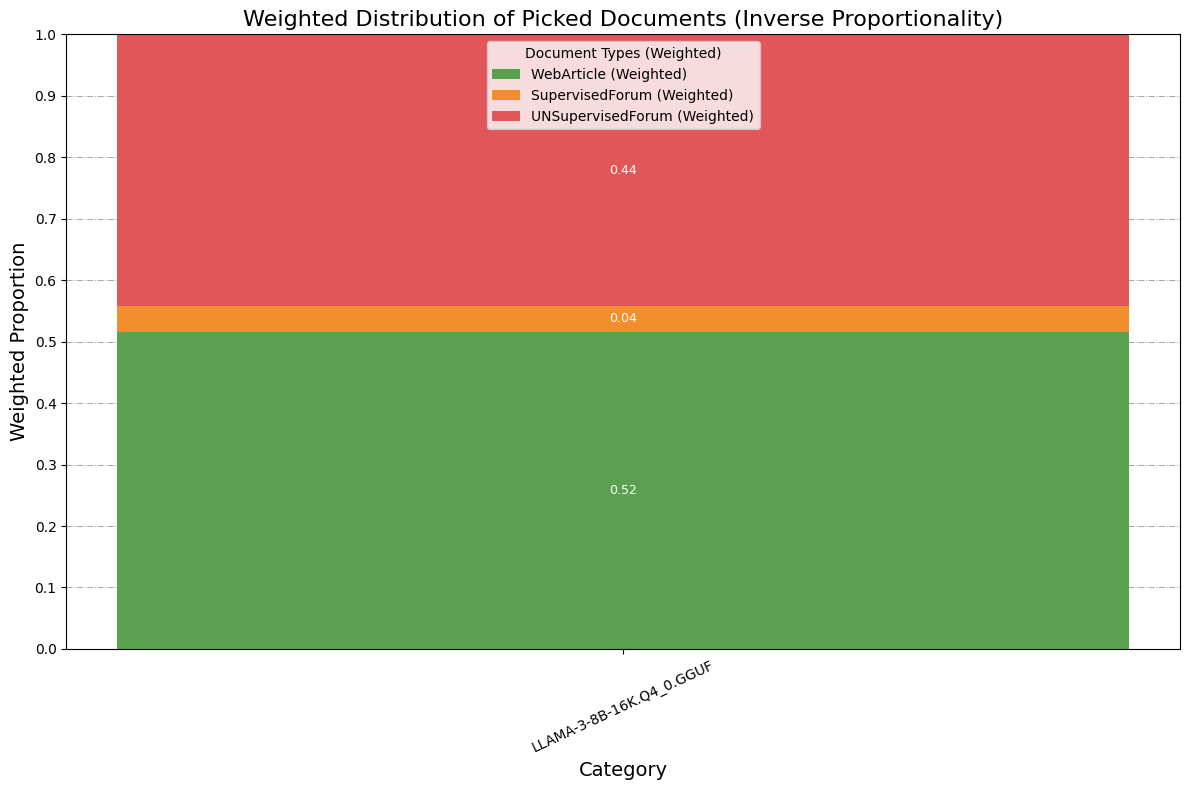

In [5]:
# Database counts
n_total = n_webarticles + n_supervised_forums + n_unsupervised_forums

# Inverse weights
w_web = 1 / (n_webarticles / n_total)  # Inverse proportion
w_supervised = 1 / (n_supervised_forums / n_total)
w_unsupervised = 1 / (n_unsupervised_forums / n_total)

# Extracting sorted data for the chart
categories = [item["category"].upper() for item in data]
easy_values = [item["diff"]["WebArticle"] for item in data]
medium_values = [item["diff"]["SupervisedForum"] for item in data]
hard_values = [item["diff"]["UNSupervisedForum"] for item in data]
total_values = [item["total"] for item in data]

# Apply weights to the retrieved counts
adjusted_easy = [count * w_web for count in easy_values]
adjusted_medium = [count * w_supervised for count in medium_values]
adjusted_hard = [count * w_unsupervised for count in hard_values]

# Compute the total adjusted counts for normalization
adjusted_total = [easy + medium + hard for easy, medium, hard in zip(adjusted_easy, adjusted_medium, adjusted_hard)]

# Compute weighted frequencies
weighted_easy = [easy / total if total > 0 else 0 for easy, total in zip(adjusted_easy, adjusted_total)]
weighted_medium = [medium / total if total > 0 else 0 for medium, total in zip(adjusted_medium, adjusted_total)]
weighted_hard = [hard / total if total > 0 else 0 for hard, total in zip(adjusted_hard, adjusted_total)]

# Reuse the previous plotting code
bar_width = 0.6
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12, 8))

# Adding horizontal grid lines
ax.grid(True, which='major', axis='y', linestyle='-.', linewidth=0.7, color='gray', alpha=0.7, zorder=0)

# Plotting bars
bars_easy = ax.bar(x, weighted_easy, bar_width, label='WebArticle (Weighted)', color=easy_color, zorder=2)
bars_medium = ax.bar(x, weighted_medium, bar_width, bottom=weighted_easy, label='SupervisedForum (Weighted)', color=medium_color, zorder=2)
bars_hard = ax.bar(x, weighted_hard, bar_width, bottom=np.add(weighted_easy, weighted_medium), label='UNSupervisedForum (Weighted)', color=hard_color, zorder=2)

# Adding labels inside the bars
for i in range(len(categories)):
    # Easy label
    if weighted_easy[i] > 0:
        ax.text(x[i], weighted_easy[i] / 2, f'{weighted_easy[i]:.2f}', ha='center', va='center', color='white', fontsize=9)
    # Medium label
    if weighted_medium[i] > 0:
        ax.text(x[i], weighted_easy[i] + weighted_medium[i] / 2, f'{weighted_medium[i]:.2f}', ha='center', va='center', color='white', fontsize=9)
    # Hard label
    if weighted_hard[i] > 0:
        ax.text(x[i], weighted_easy[i] + weighted_medium[i] + weighted_hard[i] / 2, f'{weighted_hard[i]:.2f}', ha='center', va='center', color='white', fontsize=9)

# Adjust y-axis and labels
y_axis_step = 0.1
ax.set_yticks(np.arange(0, 1.1, y_axis_step))
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Weighted Proportion', fontsize=14)
ax.set_title('Weighted Distribution of Picked Documents (Inverse Proportionality)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=25, ha='center')
ax.set_ylim(0, 1.0)

# Adding the legend
ax.legend(title='Document Types (Weighted)', loc='upper center')

plt.tight_layout()
plt.show()


# Analisi del Judge


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import json

flnm = './mistral.json'
# Open and read the JSON file
with open(flnm, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Format data like this: "category":<Nome LLM>, "total":<Somma documenti Usati> in Tutti i K, "diff":{}
# [t.results.AI.metadata.source_type for t in test_output_dicts]
# data = [
#     {"category": "theory", "total": 10, "diff": {"easy": 9, "medium": 1, "hard": 0}},
#     ...
# ]
def remap_data(run_output_dict:dict):
    plot_data =  []

    unique_list_of_model_names = list(set([test_output_dict["model_name"] for test_output_dict in run_output_dict]))

    # for metric, settings in metrics.items():
    label_name = "LLM_judge"
    for model_name in unique_list_of_model_names:
        print(f"===> [PLOT] MODEL {model_name} <===")
        # Get all the test outputs for the current model
        test_output_dicts = [test_output_dict for test_output_dict in run_output_dict if test_output_dict["model_name"] == model_name]

        for test_output_dict in test_output_dicts:
            X, Y = [],[]
            # The ith element of X is the number of documents retrieved for the ith test output with the average metric
            # Append the number of documents retrieved
            K_curr = test_output_dict["K_documents_retrieved"]

            # Get the mean metric for the current test output
            results = test_output_dict["results"]
            for i, res_obj in enumerate(results):
              # print(res_obj["AI"].keys())
              X.append(i)
              Y.append(res_obj["AI"]["judge_llm"])

            plot_data.append({"model_name":model_name, "K":K_curr, "X":X, "Y":Y})

    return plot_data

data = remap_data(data)
print(len(data)) # 13

print(data[0]["X"]) # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
print(list(len(data[i]["X"]) for i in range(len(data)))) # [101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]

print(data[0]["Y"]) # [4, 4, 4, 5, 3, 4, 4, 4, 3, 3, 3, 3, 2, 5, 3, 3, 2, 3, 3, 2, 2, 3, 5, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 5, 2, 2, 2, 1, 2, 1, 1, 1, 3, 4, 3, 3, 3, 4, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 4, 3, 3, 3, 1, 3, 4, 3, 4, 3, 3, 4, 2, 4, 3, 2, 2, 4, 3, 5, 4, 4, 2, 3, 3, 5, 4, 4, 3, 3, 2, 1, 3, 2, 4, 3]
print(list(len(data[i]["Y"]) for i in range(len(data)))) # [101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]

FileNotFoundError: [Errno 2] No such file or directory: './mistral.json'

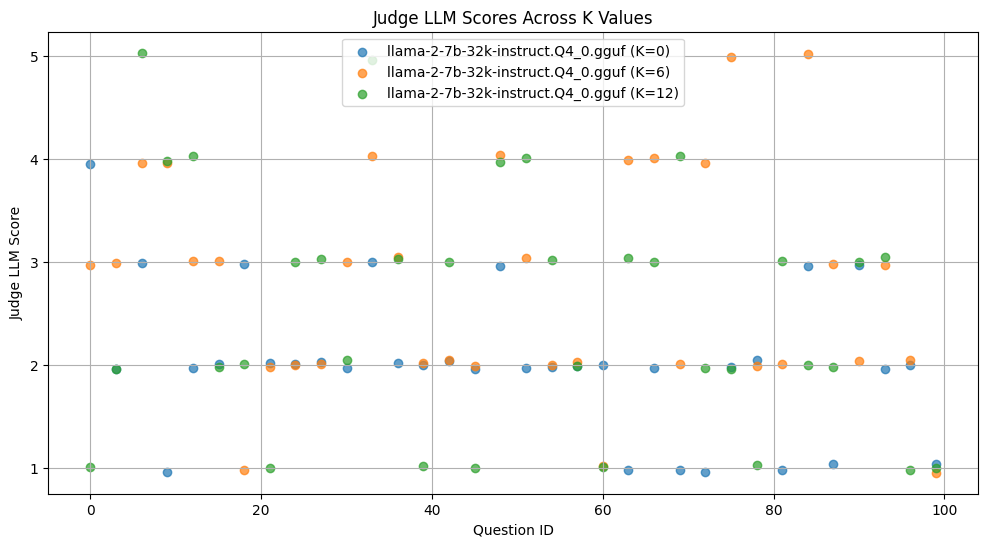

In [ ]:
def plot_data(data, skip_interval=1, jitter=0.05):
    plt.figure(figsize=(12, 6))

    for entry in data:
        model_name = entry["model_name"]
        K = entry["K"]
        X = entry["X"]
        Y = entry["Y"]
        label = f"{model_name} (K={K})"

        X_filtered = X[::skip_interval]
        Y_filtered = Y[::skip_interval]

        X_jittered = np.array(X_filtered) + np.random.uniform(-jitter, jitter, len(X_filtered))
        Y_jittered = np.array(Y_filtered) + np.random.uniform(-jitter, jitter, len(Y_filtered))
        # plt.plot(X_jittered, Y_jittered, label=label, alpha=0.7)
        plt.scatter(X_filtered, Y_jittered, label=label, alpha=0.7)

    plt.xlabel("Question ID")
    plt.ylabel("Judge LLM Score")
    plt.title("Judge LLM Scores Across K Values")
    plt.yticks([1, 2, 3, 4, 5])
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
data2 = [data[i] for i in range(0,13,6)]
plot_data(data2, skip_interval=3)

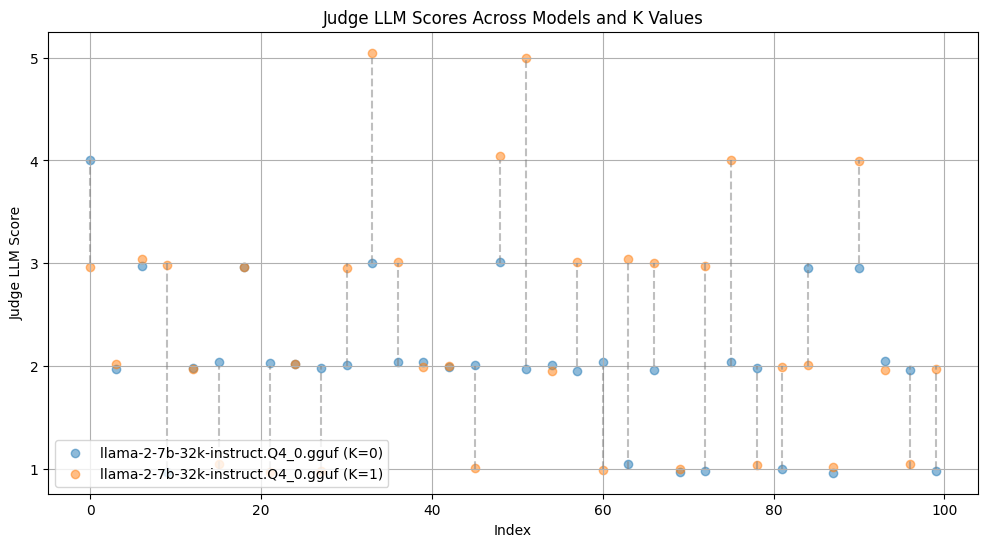

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, skip_interval=4, jitter=0.1):
    plt.figure(figsize=(12, 6))

    question_scores = {}

    for entry in data:
        X = entry["X"]
        Y = entry["Y"]
        for x, y in zip(X, Y):
            if x not in question_scores:
                question_scores[x] = []
            question_scores[x].append(y)

    X_filtered = sorted(set(x for entry in data for x in entry["X"]))[::skip_interval]

    # Add vertical bars only for question IDs in the skip interval
    for q_id in X_filtered:
        if q_id in question_scores:
            plt.vlines(x=q_id, ymin=min(question_scores[q_id]), ymax=max(question_scores[q_id]), color='gray', linestyle='--', alpha=0.5)


    for entry in data:
        model_name = entry["model_name"]
        K = entry["K"]
        X = entry["X"]
        Y = entry["Y"]
        label = f"{model_name} (K={K})"

        X_filtered_points = X[::skip_interval]
        Y_filtered_points = Y[::skip_interval]

        # Apply jitter to avoid overlapping points
        X_jittered = np.array(X_filtered_points) + np.random.uniform(-jitter, jitter, len(X_filtered_points))
        Y_jittered = np.array(Y_filtered_points) + np.random.uniform(-jitter, jitter, len(Y_filtered_points))

        plt.scatter(X_filtered_points, Y_jittered, label=label, alpha=0.5)

    plt.xlabel("Index")
    plt.ylabel("Judge LLM Score")
    plt.title("Judge LLM Scores Across Models and K Values")
    plt.yticks([1, 2, 3, 4, 5])
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Example usage
data2 = [data[i] for i in [0,1 ]]
plot_data(data2, skip_interval=3, jitter=0.05)


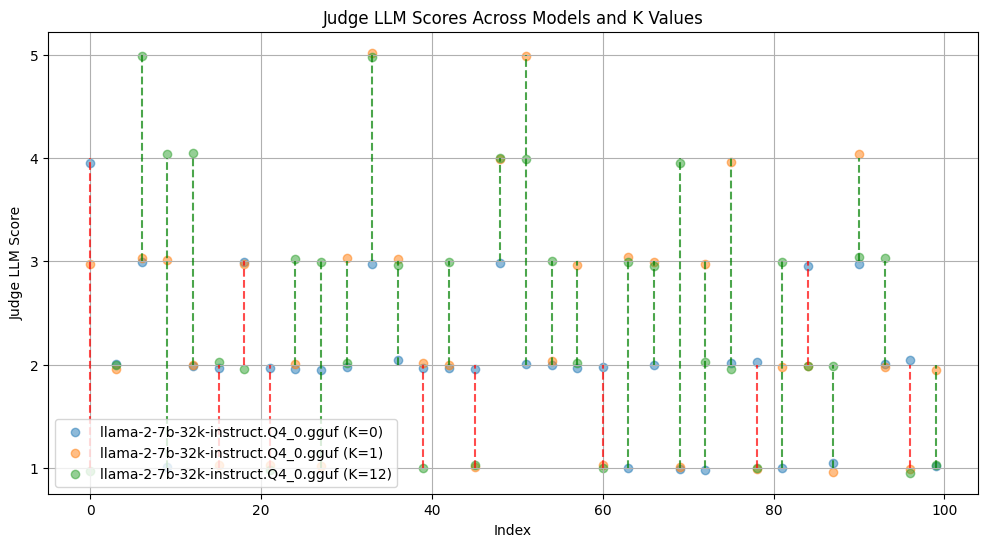

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, skip_interval=4, jitter=0.1):
    plt.figure(figsize=(12, 6))

    question_scores = {}
    question_Ks = {}

    for entry in data:
        X = entry["X"]
        Y = entry["Y"]
        K = entry["K"]
        for x, y in zip(X, Y):
            if x not in question_scores:
                question_scores[x] = []
                question_Ks[x] = []
            question_scores[x].append(y)
            question_Ks[x].append(K)

    X_filtered = sorted(set(x for entry in data for x in entry["X"]))[::skip_interval]

    # Add vertical bars only for question IDs in the skip interval
    for q_id in X_filtered:
        if q_id in question_scores:
            y_min = min(question_scores[q_id])
            y_max = max(question_scores[q_id])
            K_min = question_Ks[q_id][question_scores[q_id].index(y_min)]
            K_max = question_Ks[q_id][question_scores[q_id].index(y_max)]
            color = 'green' if K_max > K_min else 'red'
            plt.vlines(x=q_id, ymin=y_min, ymax=y_max, color=color, linestyle='--', alpha=0.7)


    for entry in data:
        model_name = entry["model_name"]
        K = entry["K"]
        X = entry["X"]
        Y = entry["Y"]
        label = f"{model_name} (K={K})"

        X_filtered_points = X[::skip_interval]
        Y_filtered_points = Y[::skip_interval]

        # Apply jitter to avoid overlapping points
        X_jittered = np.array(X_filtered_points) + np.random.uniform(-jitter, jitter, len(X_filtered_points))
        Y_jittered = np.array(Y_filtered_points) + np.random.uniform(-jitter, jitter, len(Y_filtered_points))

        plt.scatter(X_filtered_points, Y_jittered, label=label, alpha=0.5)

    plt.xlabel("Index")
    plt.ylabel("Judge LLM Score")
    plt.title("Judge LLM Scores Across Models and K Values")
    plt.yticks([1, 2, 3, 4, 5])
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Example usage
data2 = [data[i] for i in [0,1,12]]
plot_data(data2, skip_interval=3, jitter=0.05)


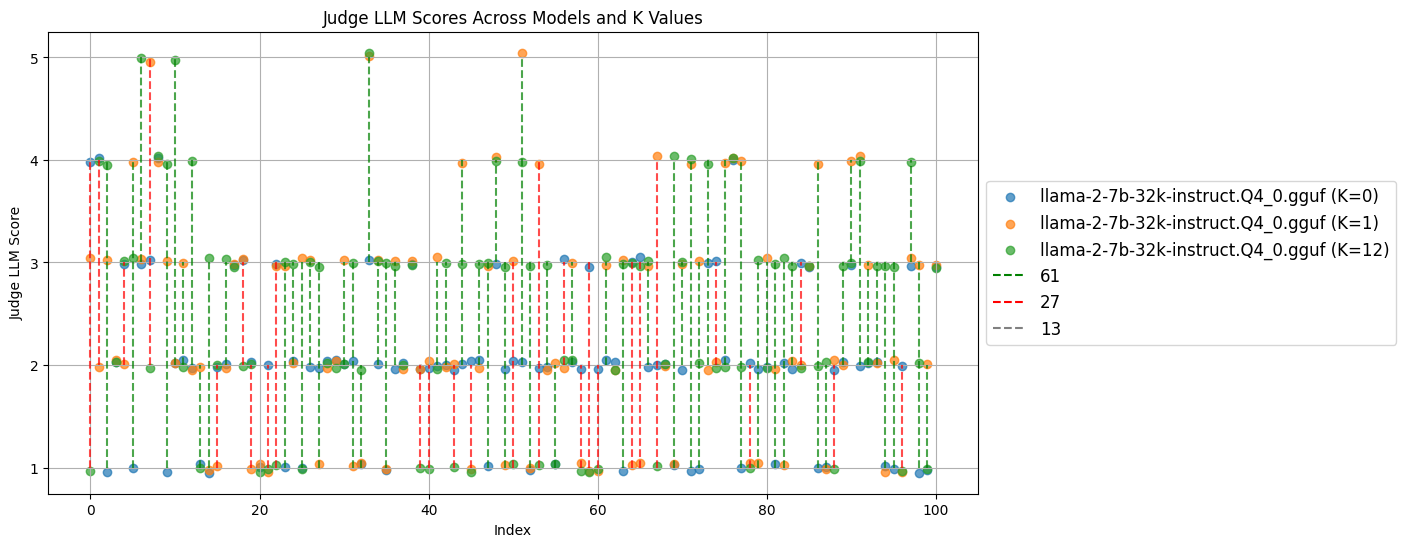

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, skip_interval=4, jitter=0.1):
    plt.figure(figsize=(12, 6))

    question_scores = {}
    question_Ks = {}
    green_line_count = 0  # Track the number of green lines
    red_line_count = 0    # Track the number of red lines
    gray_line_count = 0

    for entry in data:
        X = entry["X"]
        Y = entry["Y"]
        K = entry["K"]
        for x, y in zip(X, Y):
            if x not in question_scores:
                question_scores[x] = []
                question_Ks[x] = []
            question_scores[x].append(y)
            question_Ks[x].append(K)

    X_filtered = sorted(set(x for entry in data for x in entry["X"]))[::skip_interval]

    scatter_handles = []

    for entry in data:
        model_name = entry["model_name"]
        K = entry["K"]
        X = entry["X"]
        Y = entry["Y"]
        label = f"{model_name} (K={K})"

        X_filtered_points = X[::skip_interval]
        Y_filtered_points = Y[::skip_interval]

        # Apply jitter to avoid overlapping points
        X_jittered = np.array(X_filtered_points) + np.random.uniform(-jitter, jitter, len(X_filtered_points))
        Y_jittered = np.array(Y_filtered_points) + np.random.uniform(-jitter, jitter, len(Y_filtered_points))

        scatter_handle = plt.scatter(X_filtered_points, Y_jittered, label=label, alpha=0.7)
        scatter_handles.append(scatter_handle)

    # Add vertical bars only for question IDs in the skip interval
    for q_id in X_filtered:
        if q_id in question_scores:
            y_min = min(question_scores[q_id])
            y_max = max(question_scores[q_id])
            K_min = question_Ks[q_id][question_scores[q_id].index(y_min)]
            K_max = question_Ks[q_id][question_scores[q_id].index(y_max)]
            color = 'green' if K_max > K_min else 'red'
            color = 'gray' if K_max == K_min else color

            if color == 'green':
                green_line_count += 1  # Increment the green line counter
            elif color == 'red':
                red_line_count += 1  # Increment the red line counter
            elif color == 'gray':
                gray_line_count += 1
            plt.vlines(x=q_id, ymin=y_min, ymax=y_max, color=color, linestyle='--', alpha=0.7)

    plt.xlabel("Index")
    plt.ylabel("Judge LLM Score")
    plt.title("Judge LLM Scores Across Models and K Values")
    plt.yticks([1, 2, 3, 4, 5])

      # Create handles for the secondary legend (red/green lines)
    green_patch = plt.Line2D([0], [0], color="green", linestyle="--", label=f"{green_line_count}")
    red_patch = plt.Line2D([0], [0], color="red", linestyle="--", label=f"{red_line_count}")
    gray_patch = plt.Line2D([0], [0], color="gray", linestyle="--", label=f"{gray_line_count}")
    line_handles = [green_patch, red_patch, gray_patch]
    # Combine scatter and line legends
    all_handles = scatter_handles + line_handles
    all_labels = [handle.get_label() for handle in all_handles]

    plt.legend(handles=all_handles, labels=all_labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.grid(True)
    plt.show()

# Example usage
data2 = [data[i] for i in [0,1,12]]
plot_data(data2, skip_interval=1, jitter=0.05)


# Plot data with histograms

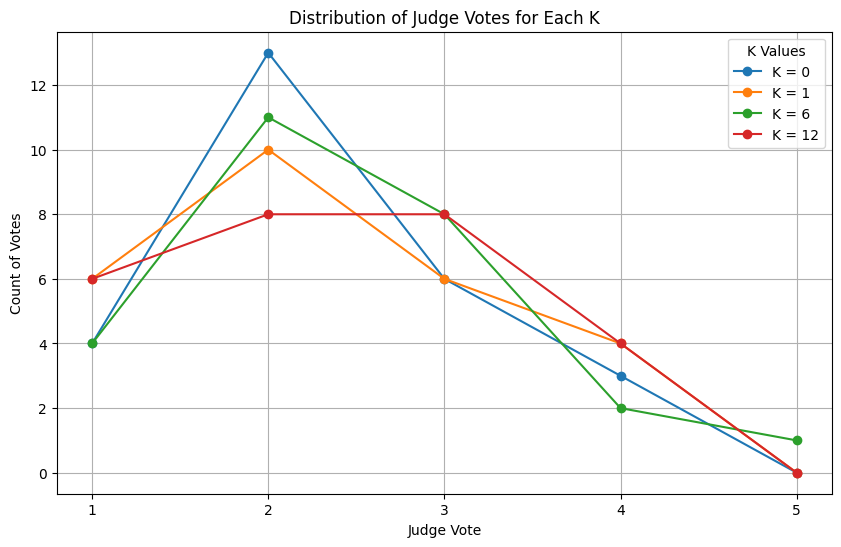

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def plot_distribution(data, skip_interval=4):
    """
    Plots the distribution of judge votes (1 to 5) for each K value.
    Only every skip_interval-th vote is considered from each entry's "Y" list.

    Parameters:
        data (list): List of dictionaries with keys "K" and "Y". "Y" is a list of votes.
        skip_interval (int): Interval at which votes are considered.
    """
    # Create a dictionary to store vote counts for each K.
    distribution_by_K = defaultdict(Counter)

    # Process each entry and count only every skip_interval-th vote.
    for entry in data:
        K = entry["K"]
        # Apply skip_interval to the list of votes.
        votes = entry["Y"][::skip_interval]
        for vote in votes:
            distribution_by_K[K][vote] += 1

    # The x-axis will be the judge vote values (from 1 to 5)
    vote_values = [1, 2, 3, 4, 5]

    plt.figure(figsize=(10, 6))

    # Plot a curve for each K value.
    for K, counter in distribution_by_K.items():
        # Get the count for each vote value, defaulting to 0 if absent.
        counts = [counter.get(vote, 0) for vote in vote_values]
        plt.plot(vote_values, counts, marker='o', label=f"K = {K}")

    plt.xlabel("Judge Vote")
    plt.ylabel("Count of Votes")
    plt.title("Distribution of Judge Votes for Each K")
    plt.legend(title="K Values")

    # Maintain y-ticks as [1, 2, 3, 4, 5]
    plt.xticks([1, 2, 3, 4, 5])

    plt.grid(True)
    plt.show()

# Example usage:
# Assuming your data is something like:
# data = [
#     {"K": 3, "Y": [1, 2, 3, 3, 4, 5], "model_name": "Model A", "X": [0, 1, 2, 3, 4, 5]},
#     {"K": 5, "Y": [2, 2, 3, 4, 4, 4], "model_name": "Model B", "X": [0, 1, 2, 3, 4, 5]},
#     # ... more entries ...
# ]
# You can call the function as follows:
data2 = [data[i] for i in [0,1,6,12]]
plot_distribution(data2)


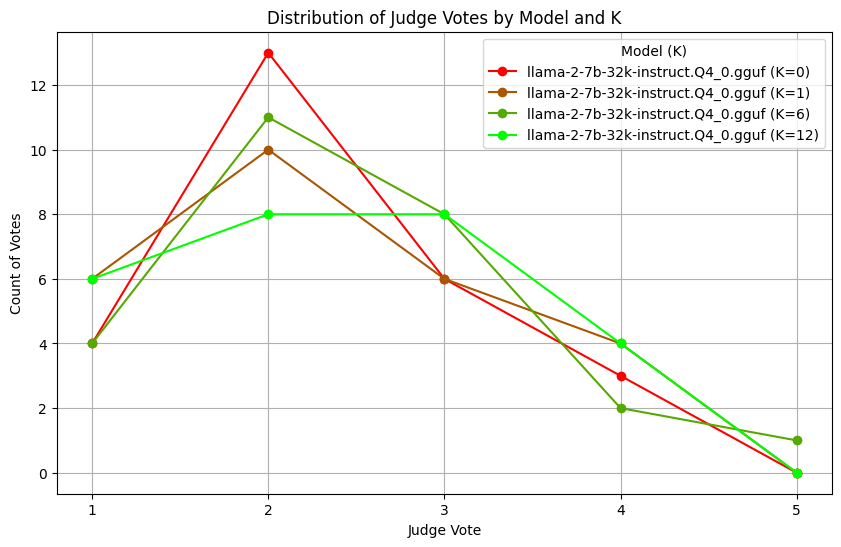

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def plot_distribution(data, skip_interval=4):
    """
    Plots the distribution of judge votes (1 to 5) for each (K, model) pair.
    Only every skip_interval-th vote is considered from each entry's "Y" list.

    The x-axis is the vote (1 to 5) and the y-axis is the count of votes.
    The curve for the lowest K is colored pure red and the highest K is pure green.
    Other curves are colored with an interpolation between red and green.

    Parameters:
        data (list): List of dictionaries with keys "K", "Y", and "model_name".
                     "Y" is a list of votes (assumed integers from 1 to 5).
        skip_interval (int): Use every skip_interval-th vote.
    """
    # Group vote counts by (K, model_name)
    distribution_by_key = defaultdict(Counter)

    for entry in data:
        K = entry["K"]
        model_name = entry.get("model_name", "Unknown Model")
        # Only take every skip_interval-th vote from Y
        votes = entry["Y"][::skip_interval]
        key = (K, model_name)
        for vote in votes:
            distribution_by_key[key][vote] += 1

    # x-axis values: judge vote values from 1 to 5.
    vote_values = [1, 2, 3, 4, 5]

    # Sort keys by K (ascending)
    sorted_keys = sorted(distribution_by_key.keys(), key=lambda k: k[0])
    n_lines = len(sorted_keys)

    plt.figure(figsize=(10, 6))

    # Plot each distribution curve.
    for idx, key in enumerate(sorted_keys):
        K, model_name = key
        counter = distribution_by_key[key]
        counts = [counter.get(vote, 0) for vote in vote_values]

        # Determine the color: interpolate between red (for lowest K) and green (for highest K).
        # If there's only one line, use pure green.
        if n_lines > 1:
            fraction = idx / (n_lines - 1)
        else:
            fraction = 1.0
        # Red is (1,0,0) and green is (0,1,0), so interpolated color:
        color = (1 - fraction, fraction, 0)

        label = f"{model_name} (K={K})"
        plt.plot(vote_values, counts, marker='o', color=color, label=label)

    plt.xlabel("Judge Vote")
    plt.ylabel("Count of Votes")
    plt.title("Distribution of Judge Votes by Model and K")
    plt.xticks([1, 2, 3, 4, 5])
    plt.legend(title="Model (K)", loc="best")
    plt.grid(True)
    plt.show()


# Example usage:
# Assuming your data is something like:
# data = [
#     {"K": 3, "Y": [1, 2, 3, 3, 4, 5], "model_name": "Model A", "X": [0, 1, 2, 3, 4, 5]},
#     {"K": 5, "Y": [2, 2, 3, 4, 4, 4], "model_name": "Model B", "X": [0, 1, 2, 3, 4, 5]},
#     # ... more entries ...
# ]
# You can call the function as follows:
data2 = [data[i] for i in [0,1,6,12]]
plot_distribution(data2)

In [ ]:
1